### the goal of this notebook is to figure out how to get the transect to start and end next to land points??

## Baby attempt at algorithm for determining transects

### some notes
`isel` with `xr` coordinate (index).\
Returns datavariable in `n` coordinate (ID).

## Part 1: Create mask
### Objective
We will use the mask to select all of the cells that appear in the original mask. We will

<ol>
    <li>Select all of the cells that appear in the original mask.</li>
    <li>Of those cells, select their corresponding vertices and edges to include inside the mask (this prevents cells from being halved if the original mask were to be applied).</li>
    <li>Select these cells, edges, and vertices in the base_mask to create a new mask.</li>
    <li>Apply this mask to the dso datavariable to plot the datavariable in the new masked area.</li>
</ol>

In [2]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
from mpas_tools.planar_hex import make_planar_hex_mesh
from mpas_tools.mesh.conversion import convert, cull, mask
from mpas_tools.io import write_netcdf
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from geometric_features import read_feature_collection
from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import json
import mosaic

In [3]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open original (from geojson file) mask to use to make dataset smaller
wmtnb_filepath = './'
mask = xr.open_dataset(wmtnb_filepath + 'LS_CEV_masks.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')

/tmp/ipykernel_1642503/3657922681.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


### functions to convert between index (xr) and ID (n) 

In [4]:
def n_to_xr_idx(n):
    return n-1

def xr_to_n_idx(xr):
    return xr+1

This code below can be rewritten to use `mesh.indexToEdgeID` or something related to it, but the I/O was messed up the day that I was doing this, so we're using the `n_to_xr_idx` and the `xr_to_n_idx` functions.
Also, just subtracting one feels easier and there is a straightforward conversion from ID (n) to index (xr) values. But the equivalent functions are below
```ruby
def xr_to_n_idx(xr):
    return xr+1
```

The equivalent conversion from  the index (xr) to ID (n) is
```ruby
cell_part = 'Cell' # 'Edge', 'Vertex'
ds = mesh
def idx_to_id(idx,cell_part,ds):
    id = ds[f'indexTo{cell_part}ID'].isel(nCells=idx).values
    return id
```

### function to get cells, edges, and vertices inside a mask

In [5]:
def xr_inside_mask_info(mesh,mask):
    # STEP 1: Select all of the cells inside teh mask
    # create mask of cells so that whole cells are included in the mask
    cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
    
    # --------- GET CELLS IN XR COORDINATES --------------
    # apply the mask to the mesh 
    # this returns cells in the xr coordinate
    xr_cells_inside = np.int32(mesh.nCells.where(cellmask,drop=True))
    
    # --------- GET VERTICES IN XR COORDINATES --------------
    
    # we also need all the vertices associated with the cells_inside masked mesh
    # this returns vertices in the n coordinate
    n_vertices_inside = mesh.verticesOnCell.isel(nCells=xr_cells_inside)
    
    # we want the vertices in the xr coordinate
    xr_vertices_inside_raw = n_to_xr_idx(n_vertices_inside)
    
    # remove repeat vertex values, remove -1 values (these were originally 0s and represented "blank" array spaces where there were fewer than 7 vertices
    xr_vertices_inside = np.delete(np.unique(xr_vertices_inside_raw), np.unique(xr_vertices_inside_raw)==-1)
    
    # --------- GET EDGES IN XR COORDINATES --------------
    
    # we also need all the edges associated with the cells_inside masked mesh
    # this returns edges in the n coordinate
    n_edges_inside = mesh.edgesOnCell.isel(nCells=xr_cells_inside)
    
    # we want  the edges in the xr coordinate
    xr_edges_inside_raw = n_to_xr_idx(n_edges_inside)
    
    # remove repeat edge values, remove -1 values (these were originally 0s and represented "blank" array spaces where there were fewer than 7 edges
    xr_edges_inside = np.delete(np.unique(xr_edges_inside_raw), np.unique(xr_edges_inside_raw)==-1)

    return xr_cells_inside, xr_vertices_inside, xr_edges_inside

## Part 2: Algorithm to create transects

## Identify transect based on desired transect location

### function to select dso data inside mask

In [6]:
def format_ds(cells_inside_ints, ds, datavariable):
    # select just the cells in the masked area
    ds_masked = ds[datavariable].isel(nCells=cells_inside_ints)

    # remove the nans
    if ds_masked.min() > 10**33:
        print('fake nans detected')
        ds_nonans = ds_masked.where(ds != ds_masked.min())
    else:
        ds_nonans = ds_masked

    # select a specific time
    ds_formatted = ds_nonans.to_dataset(name=datavariable)
    
    return ds_formatted

### function to calculate distance between 2 points on a sphere (directly copied from henri's `sectionate/section.py` script

In [7]:
def distance_on_unit_sphere(lon1, lat1, lon2, lat2, R=6.371e6, method="vincenty"):
    """
    Calculate geodesic arc distance between points (lon1, lat1) and (lon2, lat2).

    PARAMETERS:
    -----------
        lon1 : float
            Start longitude(s), in degrees
        lat1 : float
            Start latitude(s), in degrees
        lon2 : float
            End longitude(s), in degrees
        lat2 : float
            End latitude(s), in degrees
        R : float
            Radius of sphere. Default: 6.371e6 (realistic Earth value). Set to 1 for
            arc distance in radius.
        method : str
            Name of method. Supported methods: ["vincenty", "haversine", "law of cosines"].
            Default: "vincenty", which is the most robust. Note, however, that it still can result in
            vanishingly small (but crucially non-zero) errors; such as that the distance between (0., 0.)
            and (360., 0.) is 1.e-16 meters when it should be identically zero.

    RETURNS:
    --------

    dist : float
        Geodesic distance between points (lon1, lat1) and (lon2, lat2).
    """
    
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    dphi = np.abs(phi2-phi1)
    
    lam1 = np.deg2rad(lon1)
    lam2 = np.deg2rad(lon2)
    dlam = np.abs(lam2-lam1)
    
    if method=="vincenty":
        numerator = np.sqrt(
            (np.cos(phi2)*np.sin(dlam))**2 +
            (np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlam))**2
        )
        denominator = np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(dlam)
        arc = np.arctan2(numerator, denominator)
        
    elif method=="haversine":
        arc = 2*np.arcsin(np.sqrt(
            np.sin(dphi/2.)**2 + (1. - np.sin(dphi/2.)**2 - np.sin((phi1+phi2)/2.)**2)*np.sin(dlam/2.)**2
        ))
    
        
    elif method=="law of cosines":
        arc = np.arccos(
            np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(dlam)
        )

    return R * arc


An attempt at the algorithm that ignores taking the shortest geodesic path (based on arc angle and the idea of a great circle) and instead just take the shortest distance.

In [8]:
print(mesh.lonVertex.max(),mesh.lonVertex.min())

<xarray.DataArray 'lonVertex' ()> Size: 8B
array(6.28317757) <xarray.DataArray 'lonVertex' ()> Size: 8B
array(3.67336638e-06)


In [9]:
print(mesh.latVertex.max(),mesh.latVertex.min())

<xarray.DataArray 'latVertex' ()> Size: 8B
array(1.568576) <xarray.DataArray 'latVertex' ()> Size: 8B
array(-1.37380175)


In [10]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

In [11]:
# ---------- INITIATE START VERTEX ----------------
# of these transect cells, select the one that is closest to the desired starting point.
# desired values in deg
# # LS
# target_start_lat, target_start_lon = 54, 302
# target_end_lat, target_end_lon = 60, 315

# GofM
target_start_lat, target_start_lon = 20, 270
target_end_lat, target_end_lon = 26, 280

# distance_on_unit_sphere(lon1, lat1, lon2, lat 2)
# find the shortest path between the two points
# of all of the points, find the vertex that is closest to the desired start point
distance = distance_on_unit_sphere(mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_start_lon, target_start_lat)
xr_start_vertex = distance.argmin()
n_start_vertex = xr_to_n_idx(xr_start_vertex)
print('started at n vertex ', n_start_vertex.values)

# repeat to find the vertex that is closest to the desired end point
dist_to_end = distance_on_unit_sphere(mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_end_lon, target_end_lat)
xr_end_vertex = dist_to_end.argmin()
end_lon = mesh.isel(nVertices = xr_end_vertex).lonVertex * 180/np.pi
end_lat = mesh.isel(nVertices = xr_end_vertex).latVertex * 180/np.pi

# ---------- FIND NEXT VERTEX ----------------
start_vertices = np.array([])
next_vertices = np.array([])

count = 0

while distance.min() > 5000:
    # get the edges attached to the start vertex
    n_edgesOnStartVertex = mesh.edgesOnVertex.isel(nVertices = xr_start_vertex)
    xr_edgesOnStartVertex = n_to_xr_idx(n_edgesOnStartVertex)
    
    # check that the edges you selected are connected to the start vertex (returns in n indices)
    # mesh.verticesOnEdge.isel(nEdges = xr_edgesOnStartVertex[0])
    
    # for each of these edges, find the vertices they are connected to and then remove the start_vertex (we don't want to "travel back" to that vertex)
    n_vertices_nextToStartVertex = np.unique(mesh.verticesOnEdge.isel(nEdges = xr_edgesOnStartVertex))
    xr_vertices_nextToStartVertex = n_to_xr_idx(n_vertices_nextToStartVertex)
    # print(xr_vertices_nextToStartVertex)

    used_vertices = np.union1d(start_vertices, xr_start_vertex)
    
    xr_vertices_nextToStartVertex_Use = np.delete(xr_vertices_nextToStartVertex, np.where(np.isin(xr_vertices_nextToStartVertex, used_vertices)))
    # print(xr_vertices_nextToStartVertex_Use)
    # calculate the distance from these new vertices to the desired end point
        # retrieve the lat and lon of the vertex
    ds_vertices_nextLatLon = mesh[['lonVertex','latVertex']].where(mesh.nVertices.isin(xr_vertices_nextToStartVertex_Use))
    ds_vertices_nextLatLon['lonVertex'] = ds_vertices_nextLatLon.lonVertex * 180 / np.pi
    ds_vertices_nextLatLon['latVertex'] = ds_vertices_nextLatLon.latVertex * 180 / np.pi
    
        # calculate the distance between the next vertices and the end
    distance = distance_on_unit_sphere(ds_vertices_nextLatLon.lonVertex, ds_vertices_nextLatLon.latVertex, end_lon, end_lat)
    
        # select the nVertex that is the shortest distance from the end point
    xr_chosen_nextVertex = distance.argmin()
    
    # ---------- UPDATE ARRAYS ----------------
    # store vertices
    start_vertices = np.append(start_vertices, xr_start_vertex)
    next_vertices = np.append(next_vertices, xr_chosen_nextVertex)

    xr_start_vertex = xr_chosen_nextVertex 

    if count%100==0:
        print('(lon,lat)= (', mesh.lonVertex.isel(nVertices=xr_chosen_nextVertex).values * 180/np.pi, mesh.latVertex.isel(nVertices=xr_chosen_nextVertex).values * 180/np.pi, ')')
        print('xr vertex = ', xr_start_vertex.values)
    count +=1
    if distance.min() < 10000: # 1 grid cell ~ 100km. distance is measured in meters (see R units) 
        break
    # if count > 35:
    #     break

    

started at n vertex  45406
(lon,lat)= ( 269.5169101999615 20.19135104755908 )
xr vertex =  311377


<div class="alert alert-warning" role="alert">
  <b>This only works if you are very specific with at what count the algorithm should stop. Otherwise you get a blob (cells keep getting selected). </b> I think this is because I need to ID end cells that are inside the ocean. 
</div>

**If you choose an end point in the middle of land, then the `distance < 10,000m` condition may never be met because there are no ocean cells within that distance to the land end point?**

In [12]:
mesh.edgesOnCell

<xarray.DataArray 'edgesOnCell' (nCells: 236853, maxEdges: 7)> Size: 7MB
[1657971 values with dtype=int32]
Dimensions without coordinates: nCells, maxEdges
Attributes:
    units:      unitless
    long_name:  List of edges that border each cell.

In [13]:
next_vertices

array([311377., 390563., 123806., 242411., 110922., 304529., 296083.,
       434043., 374967., 352710., 365646., 138558., 302573., 158618.,
        67104., 392625.,  15355., 245366., 456513., 368114., 282483.,
       231204., 119700., 352555., 401517., 436851.,  81633., 467955.,
       303555., 405273., 429450., 355460., 110353., 183196.,  24074.,
        73069., 121996., 394749., 280413., 326480., 257587., 331731.,
       196119.,   8942.,  21398., 387329., 249399.,  35398., 293394.,
       291937.,  19972., 343549., 454674., 309825.])

(15.0, 35.0)

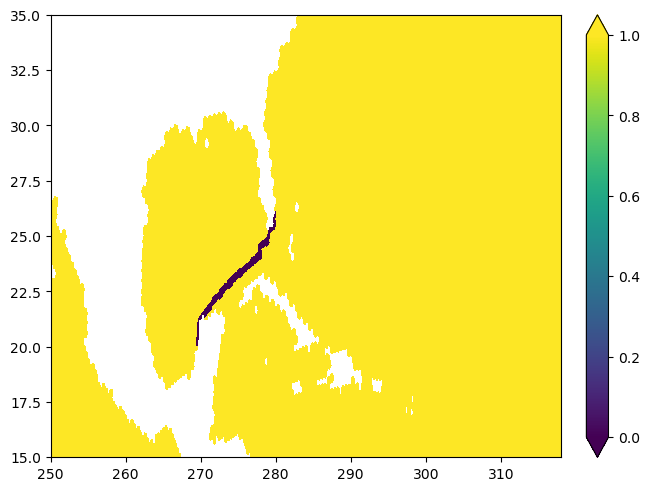

In [14]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=0)

# GofM
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=1)

vertexmask = base_mask.regionVertexMasks.isel(nRegions=0).astype(bool)

# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  vertexmask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')

# LS
ax.set_xlim(300, 318)
ax.set_ylim(51.5, 68)

# GofM
ax.set_xlim(250, 318)
ax.set_ylim(15, 35)

In [15]:
# get the edges connected to a cell with the xr_ID of 0 (isel(nCells=0)). Then choose the first edge of that cell
# returns edges in the n coordinate
edge_nCell0_0 = mesh.edgesOnCell.isel(nCells=0).values[0] 
display(edge_nCell0_0)

# convert the edge in the n coordinate to the xr coordinate (xr = n -1) 
xr_edge_nCell0_0 = edge_nCell0_0 -1
display(xr_edge_nCell0_0)

# check our work 
# get the cells connected to an edge identified with xr_ID and n
mesh.cellsOnEdge.isel(nEdges=xr_edge_nCell0_0).values
# indices returned in the ncell indices

np.int32(288637)

np.int32(288636)

array([     1, 234052], dtype=int32)

In [16]:
# get the vertices connected to a cell with the xr_ID of 0 (isel(nCells=0)). then choose the first vertex of that cell
# returns vertices in the n coordinate
nCell_idx = 0
vert_nCell0_0 = mesh.verticesOnCell.isel(nCells=nCell_idx).values[0]
display(vert_nCell0_0)

# convert the vertex in the n coordinate to the xr coordinate (xr = n-1)
xr_vert_nCell0_0 = n_to_xr_idx(vert_nCell0_0)
display(xr_vert_nCell0_0)

# check our work
# get the cells connected to the vertex identified with xr_ID and n
nCell_vert31235_0 = mesh.cellsOnVertex.isel(nVertices = xr_vert_nCell0_0).values

# indices returned in the ncell indices. Convert ncell index to xr index
nCell_from_vertex = n_to_xr_idx(nCell_vert31235_0)
display(nCell_from_vertex)


np.int32(31236)

np.int32(31235)

array([234050,      0, 234051], dtype=int32)